<a href="https://colab.research.google.com/github/simunna303/Cse445_Machine-Learning_Project/blob/main/Cse445_Predict_the_positions_and_speeds_of_600_satellites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from google.colab import drive
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics

In [2]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
satellite = pd.read_csv('/content/drive/MyDrive/445ml/jantrain.csv')

In [4]:
#check unique values
satellite.apply(lambda x: len(x.unique()))

id        503227
epoch     502553
sat_id       600
x         503227
y         503227
z         503227
Vx        503227
Vy        503227
Vz        503227
x_sim     503227
y_sim     503227
z_sim     503227
Vx_sim    503227
Vy_sim    503227
Vz_sim    503227
dtype: int64

In [5]:
satellite.head()

id                    epoch  sat_id  ...    Vx_sim    Vy_sim    Vz_sim
0   0  2014-01-01 00:00:00.000       0  ... -0.907527 -3.804930 -2.024133
1   1  2014-01-01 00:46:43.000       0  ... -0.303704 -4.269816 -0.616468
2   2  2014-01-01 01:33:26.001       0  ...  0.274880 -4.046788  0.718768
3   3  2014-01-01 02:20:09.001       0  ...  0.712437 -3.375202  1.718306
4   4  2014-01-01 03:06:52.002       0  ...  0.989382 -2.522618  2.342237

[5 rows x 15 columns]

In [6]:
#info about datatype
satellite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503227 entries, 0 to 503226
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      503227 non-null  int64  
 1   epoch   503227 non-null  object 
 2   sat_id  503227 non-null  int64  
 3   x       503227 non-null  float64
 4   y       503227 non-null  float64
 5   z       503227 non-null  float64
 6   Vx      503227 non-null  float64
 7   Vy      503227 non-null  float64
 8   Vz      503227 non-null  float64
 9   x_sim   503227 non-null  float64
 10  y_sim   503227 non-null  float64
 11  z_sim   503227 non-null  float64
 12  Vx_sim  503227 non-null  float64
 13  Vy_sim  503227 non-null  float64
 14  Vz_sim  503227 non-null  float64
dtypes: float64(12), int64(2), object(1)
memory usage: 57.6+ MB


In [7]:
#missing values
satellite.isnull().sum()

id        0
epoch     0
sat_id    0
x         0
y         0
z         0
Vx        0
Vy        0
Vz        0
x_sim     0
y_sim     0
z_sim     0
Vx_sim    0
Vy_sim    0
Vz_sim    0
dtype: int64

In [8]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [9]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [10]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [11]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# answer_key.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/content/drive/MyDrive/445ml/jantrain.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'jantrain.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 15 columns


In [12]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# answer_key.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df2 = pd.read_csv('/content/drive/MyDrive/445ml/jan_test.csv', delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'jan_test.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 9 columns


In [13]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# answer_key.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df3 = pd.read_csv('/content/drive/MyDrive/445ml/answer_key.csv', delimiter=',', nrows = nRowsRead)
df3.dataframeName = 'answer_key.csv'
nRow, nCol = df3.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 6 columns


In [14]:
df1.head(5)

id                    epoch  sat_id  ...    Vx_sim    Vy_sim    Vz_sim
0   0  2014-01-01 00:00:00.000       0  ... -0.907527 -3.804930 -2.024133
1   1  2014-01-01 00:46:43.000       0  ... -0.303704 -4.269816 -0.616468
2   2  2014-01-01 01:33:26.001       0  ...  0.274880 -4.046788  0.718768
3   3  2014-01-01 02:20:09.001       0  ...  0.712437 -3.375202  1.718306
4   4  2014-01-01 03:06:52.002       0  ...  0.989382 -2.522618  2.342237

[5 rows x 15 columns]

In [15]:
df2.head(5)

id                    epoch  sat_id  ...    Vx_sim    Vy_sim    Vz_sim
0  741  2014-01-25 00:10:20.368       0  ... -1.534768 -0.036194 -3.543123
1  742  2014-01-25 00:57:03.369       0  ... -1.569222 -1.322302 -3.580785
2  743  2014-01-25 01:43:46.369       0  ... -1.376563 -2.703735 -3.090802
3  744  2014-01-25 02:30:29.370       0  ... -0.926840 -3.807767 -2.016147
4  745  2014-01-25 03:17:12.370       0  ... -0.322902 -4.269041 -0.606292

[5 rows x 9 columns]

In [16]:
df3.head(5)

x             y             z        Vx        Vy        Vz
0  7532.838464  28142.427773  16447.206347 -1.339892  1.066093 -3.122314
1  3496.786213  29816.542717   7091.835310 -1.524733  0.078967 -3.516343
2  -892.277257  28322.345197  -2974.463116 -1.577600 -1.184553 -3.597230
3 -5140.552632  23053.303054 -12593.864902 -1.410630 -2.571412 -3.167409
4 -8552.378514  14123.938571 -20166.609401 -0.983303 -3.724114 -2.145066

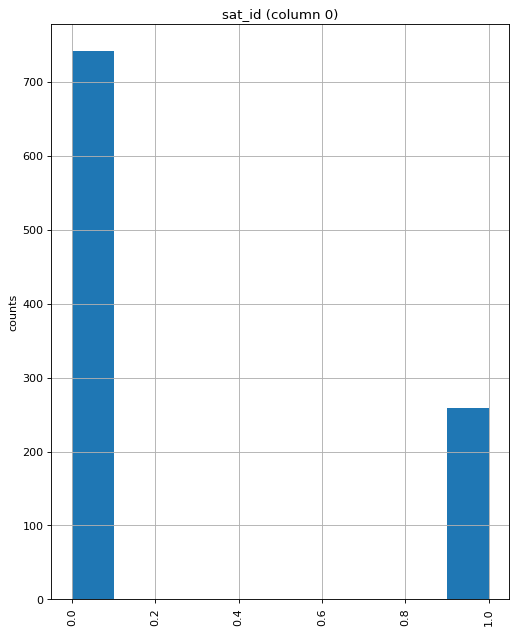

In [17]:
plotPerColumnDistribution(df1, 10, 5)


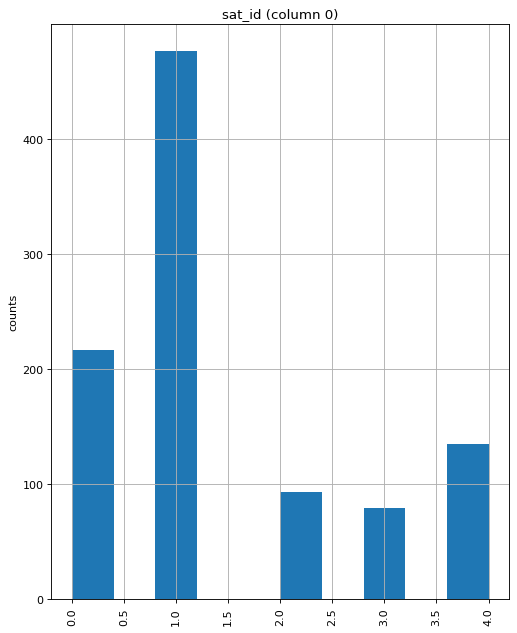

In [18]:
plotPerColumnDistribution(df2, 10, 5)

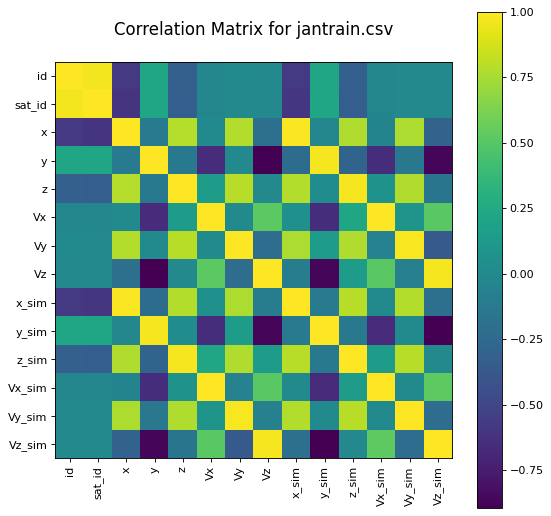

In [19]:
plotCorrelationMatrix(df1, 8)

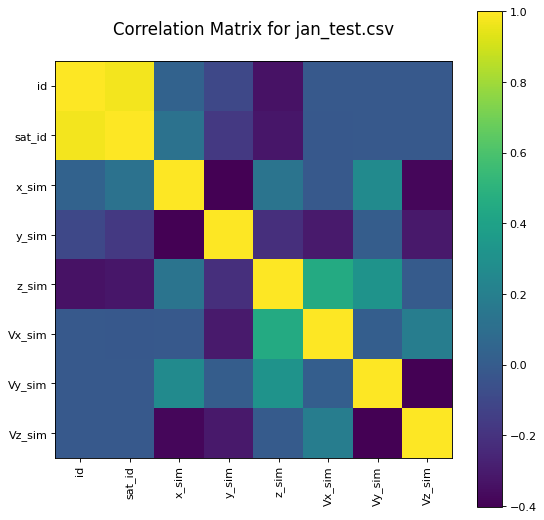

In [20]:
plotCorrelationMatrix(df2, 8)

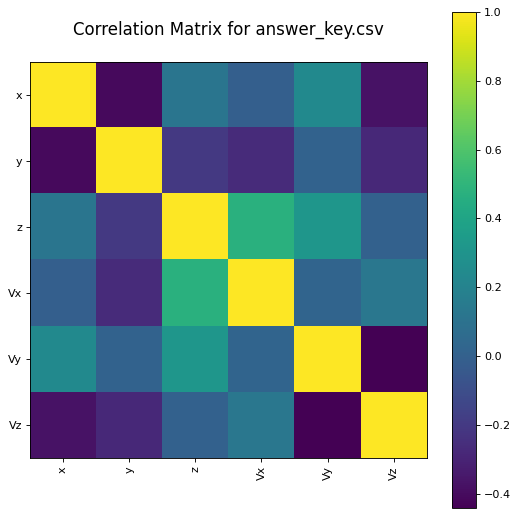

In [21]:
plotCorrelationMatrix(df3, 8)

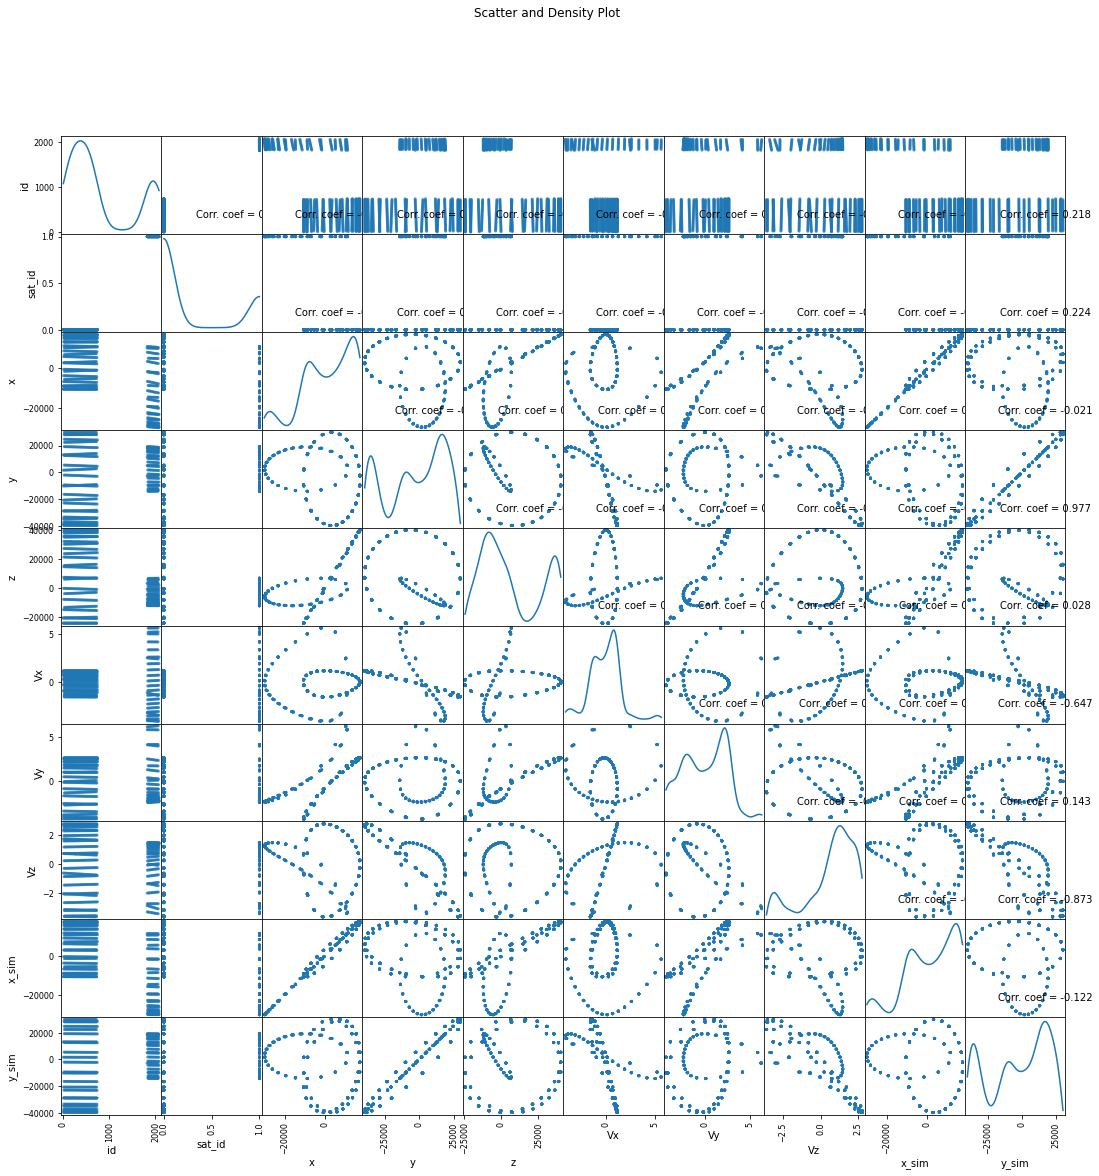

In [22]:
plotScatterMatrix(df1, 18, 10)

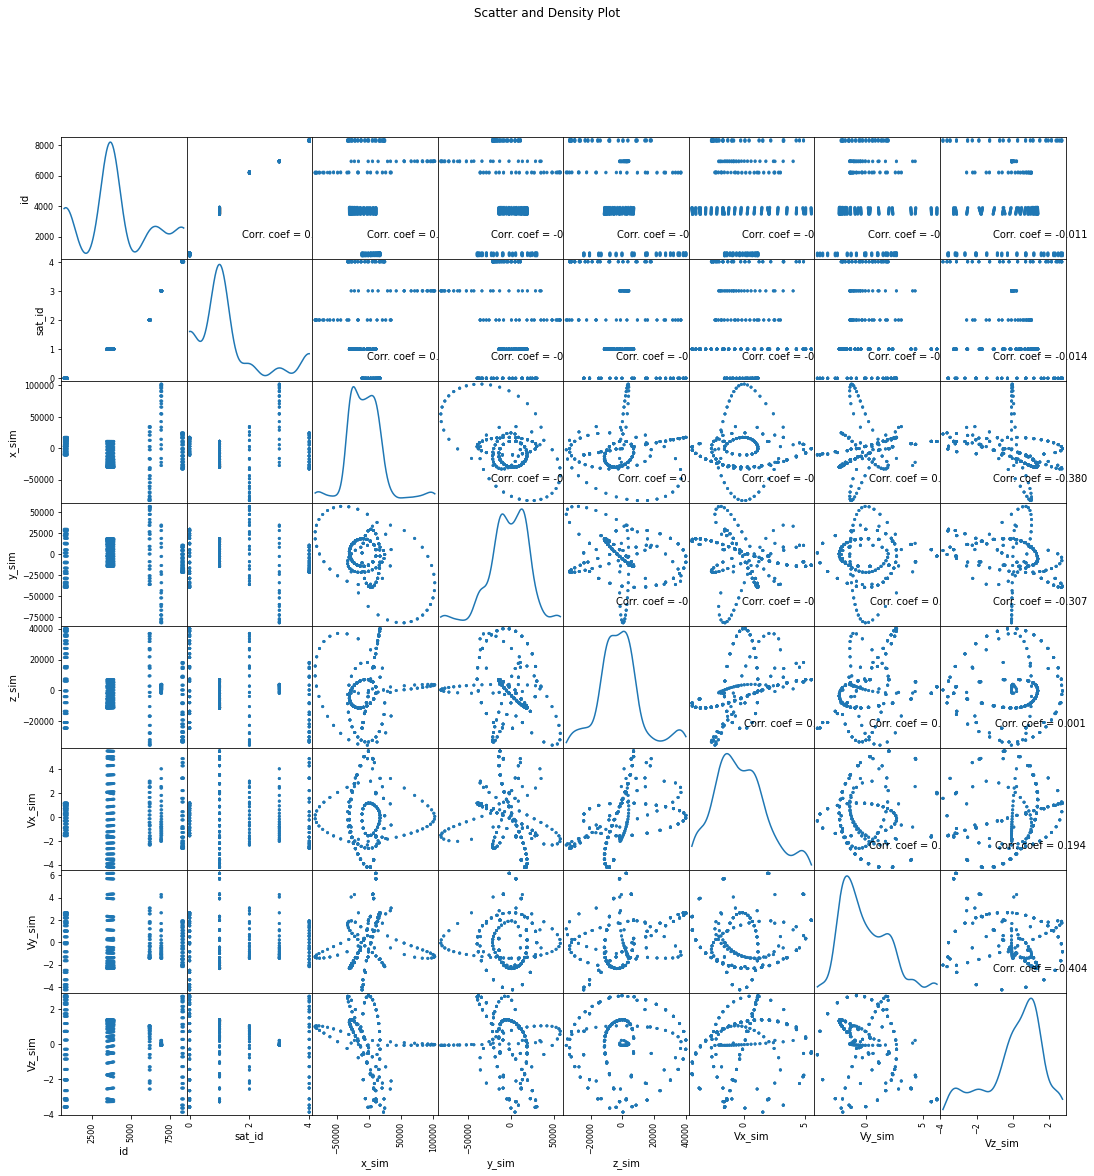

In [23]:
plotScatterMatrix(df2, 18, 10)

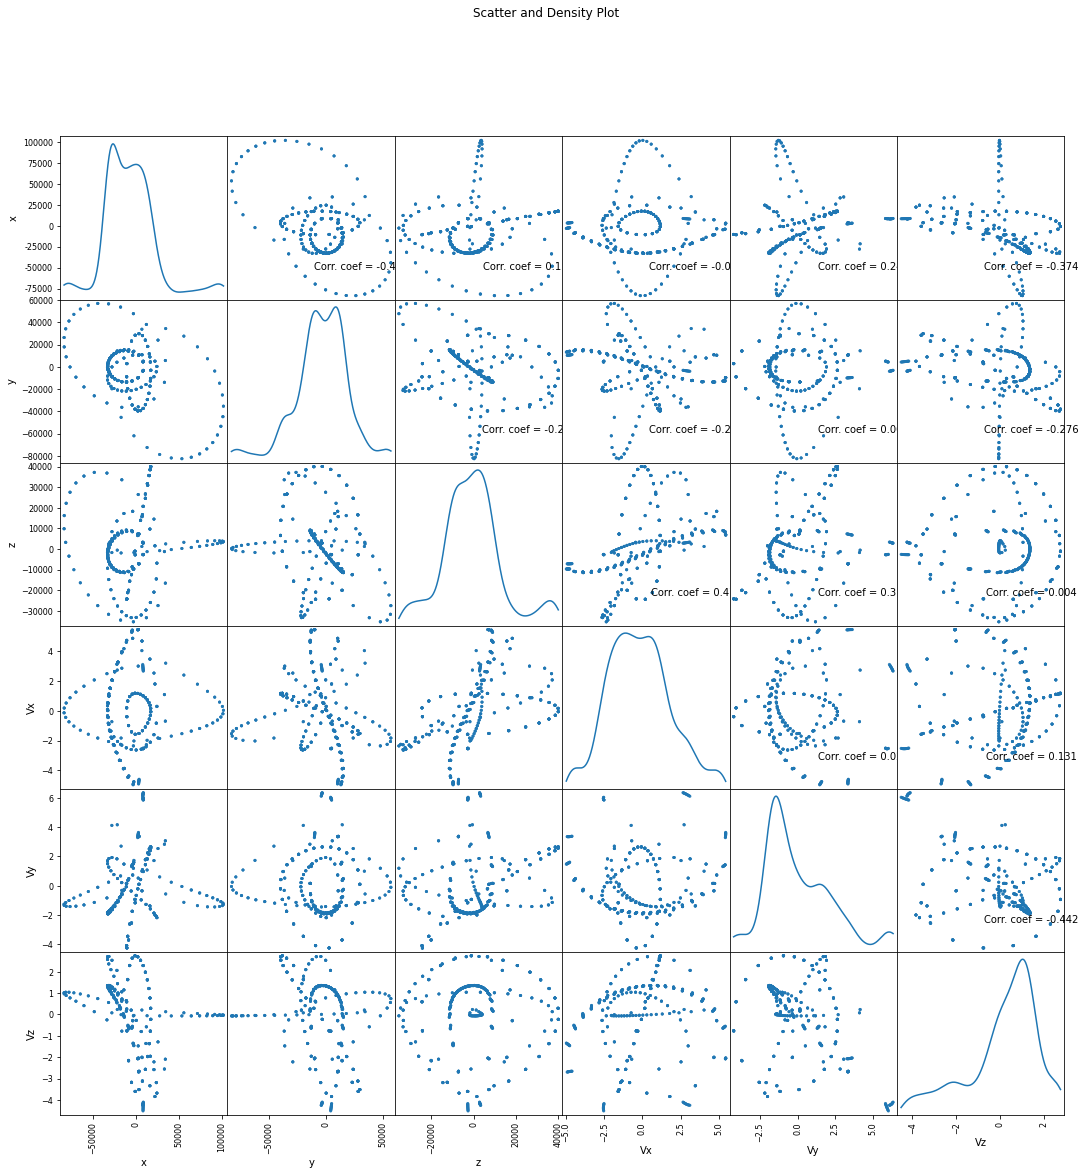

In [24]:
plotScatterMatrix(df3, 18, 10)

In [25]:
print(satellite.shape)

(503227, 15)


In [26]:
data=satellite.drop(columns = ['id'])
data.head()

epoch  sat_id             x  ...    Vx_sim    Vy_sim    Vz_sim
0  2014-01-01 00:00:00.000       0  -8855.823863  ... -0.907527 -3.804930 -2.024133
1  2014-01-01 00:46:43.000       0 -10567.672384  ... -0.303704 -4.269816 -0.616468
2  2014-01-01 01:33:26.001       0 -10578.684043  ...  0.274880 -4.046788  0.718768
3  2014-01-01 02:20:09.001       0  -9148.251857  ...  0.712437 -3.375202  1.718306
4  2014-01-01 03:06:52.002       0  -6719.092336  ...  0.989382 -2.522618  2.342237

[5 rows x 14 columns]

In [27]:
print(data.shape)

(503227, 14)


In [28]:
data['epoch'] = pd.to_datetime(data['epoch'])    
data['epoch'] = (data['epoch'] - data['epoch'].min())  / np.timedelta64(1,'D')
data.head(10000)

epoch  sat_id             x  ...    Vx_sim    Vy_sim    Vz_sim
0      0.000000       0  -8855.823863  ... -0.907527 -3.804930 -2.024133
1      0.032442       0 -10567.672384  ... -0.303704 -4.269816 -0.616468
2      0.064884       0 -10578.684043  ...  0.274880 -4.046788  0.718768
3      0.097326       0  -9148.251857  ...  0.712437 -3.375202  1.718306
4      0.129769       0  -6719.092336  ...  0.989382 -2.522618  2.342237
...         ...     ...           ...  ...       ...       ...       ...
9995  10.423981      10   -843.083356  ...  2.781681  1.515283  1.017317
9996  10.441559      10   3414.741175  ...  2.628788  2.058669  1.590907
9997  10.459138      10   7527.203568  ...  2.261222  2.670992  2.272664
9998  10.476716      10  11224.818145  ...  1.512291  3.336165  3.076637
9999  10.494295      10  14040.714068  ...  0.057241  3.930216  3.937146

[10000 rows x 14 columns]

In [29]:
data.values

array([[ 0.00000000e+00,  0.00000000e+00, -8.85582386e+03, ...,
        -9.07526561e-01, -3.80492982e+00, -2.02413344e+00],
       [ 3.24421296e-02,  0.00000000e+00, -1.05676724e+04, ...,
        -3.03703719e-01, -4.26981610e+00, -6.16468474e-01],
       [ 6.48842708e-02,  0.00000000e+00, -1.05786840e+04, ...,
         2.74880377e-01, -4.04678761e+00,  7.18768459e-01],
       ...,
       [ 2.39640700e+01,  5.99000000e+02, -1.50646165e+04, ...,
         3.18633456e+00,  3.31571655e+00, -8.65265545e-01],
       [ 2.39813227e+01,  5.99000000e+02, -8.95321136e+03, ...,
         4.25361429e+00,  2.27671990e+00, -9.96589231e-01],
       [ 2.39985755e+01,  5.99000000e+02, -1.71712972e+03, ...,
         4.94542777e+00,  7.70714969e-01, -1.02029778e+00]])

In [30]:
data.columns

Index(['epoch', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'x_sim', 'y_sim',
       'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'],
      dtype='object')

In [31]:
x = data[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']]

In [32]:
y = data[['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']]

In [33]:
data = data[['x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']]

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503227 entries, 0 to 503226
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       503227 non-null  float64
 1   y       503227 non-null  float64
 2   z       503227 non-null  float64
 3   Vx      503227 non-null  float64
 4   Vy      503227 non-null  float64
 5   Vz      503227 non-null  float64
 6   x_sim   503227 non-null  float64
 7   y_sim   503227 non-null  float64
 8   z_sim   503227 non-null  float64
 9   Vx_sim  503227 non-null  float64
 10  Vy_sim  503227 non-null  float64
 11  Vz_sim  503227 non-null  float64
dtypes: float64(12)
memory usage: 46.1 MB


In [35]:
print(x)

                   x             y             z        Vx        Vy        Vz
0       -8855.823863  13117.780146 -20728.353233 -0.908303 -3.808436 -2.022083
1      -10567.672384   1619.746066 -24451.813271 -0.302590 -4.272617 -0.612796
2      -10578.684043 -10180.467460 -24238.280949  0.277435 -4.047522  0.723155
3       -9148.251857 -20651.437460 -20720.381279  0.715600 -3.373762  1.722115
4       -6719.092336 -28929.061629 -14938.907967  0.992507 -2.519732  2.344703
...              ...           ...           ...       ...       ...       ...
503222 -22282.245721   2176.275085   4184.918699  1.255727  4.018148 -0.540243
503223 -19551.683596   7997.489974   3224.501905  2.419800  3.729286 -0.746051
503224 -15064.616469  13079.761912   1975.820551  3.587560  3.009816 -0.920914
503225  -8953.211355  16721.787269    516.231786  4.556922  1.794477 -1.020603
503226  -1717.129724  18218.471698  -1004.927645  5.049138  0.162277 -0.996545

[503227 rows x 6 columns]


In [36]:
print(y)

               x_sim         y_sim         z_sim    Vx_sim    Vy_sim    Vz_sim
0       -8843.131454  13138.221690 -20741.615306 -0.907527 -3.804930 -2.024133
1      -10555.500066   1649.289367 -24473.089556 -0.303704 -4.269816 -0.616468
2      -10571.858472 -10145.939908 -24271.169776  0.274880 -4.046788  0.718768
3       -9149.620794 -20618.200201 -20765.019094  0.712437 -3.375202  1.718306
4       -6729.358857 -28902.271436 -14992.399986  0.989382 -2.522618  2.342237
...              ...           ...           ...       ...       ...       ...
503222 -22847.208402     80.070907   4444.798405  0.870781  4.035965 -0.467196
503223 -20717.460440   6016.252299   3592.204365  2.003622  3.872352 -0.675867
503224 -16847.612994  11429.130312   2439.160526  3.186335  3.315717 -0.865266
503225 -11273.779239  15659.892239   1041.308701  4.253614  2.276720 -0.996589
503226  -4352.858942  17980.888207   -478.128914  4.945428  0.770715 -1.020298

[503227 rows x 6 columns]


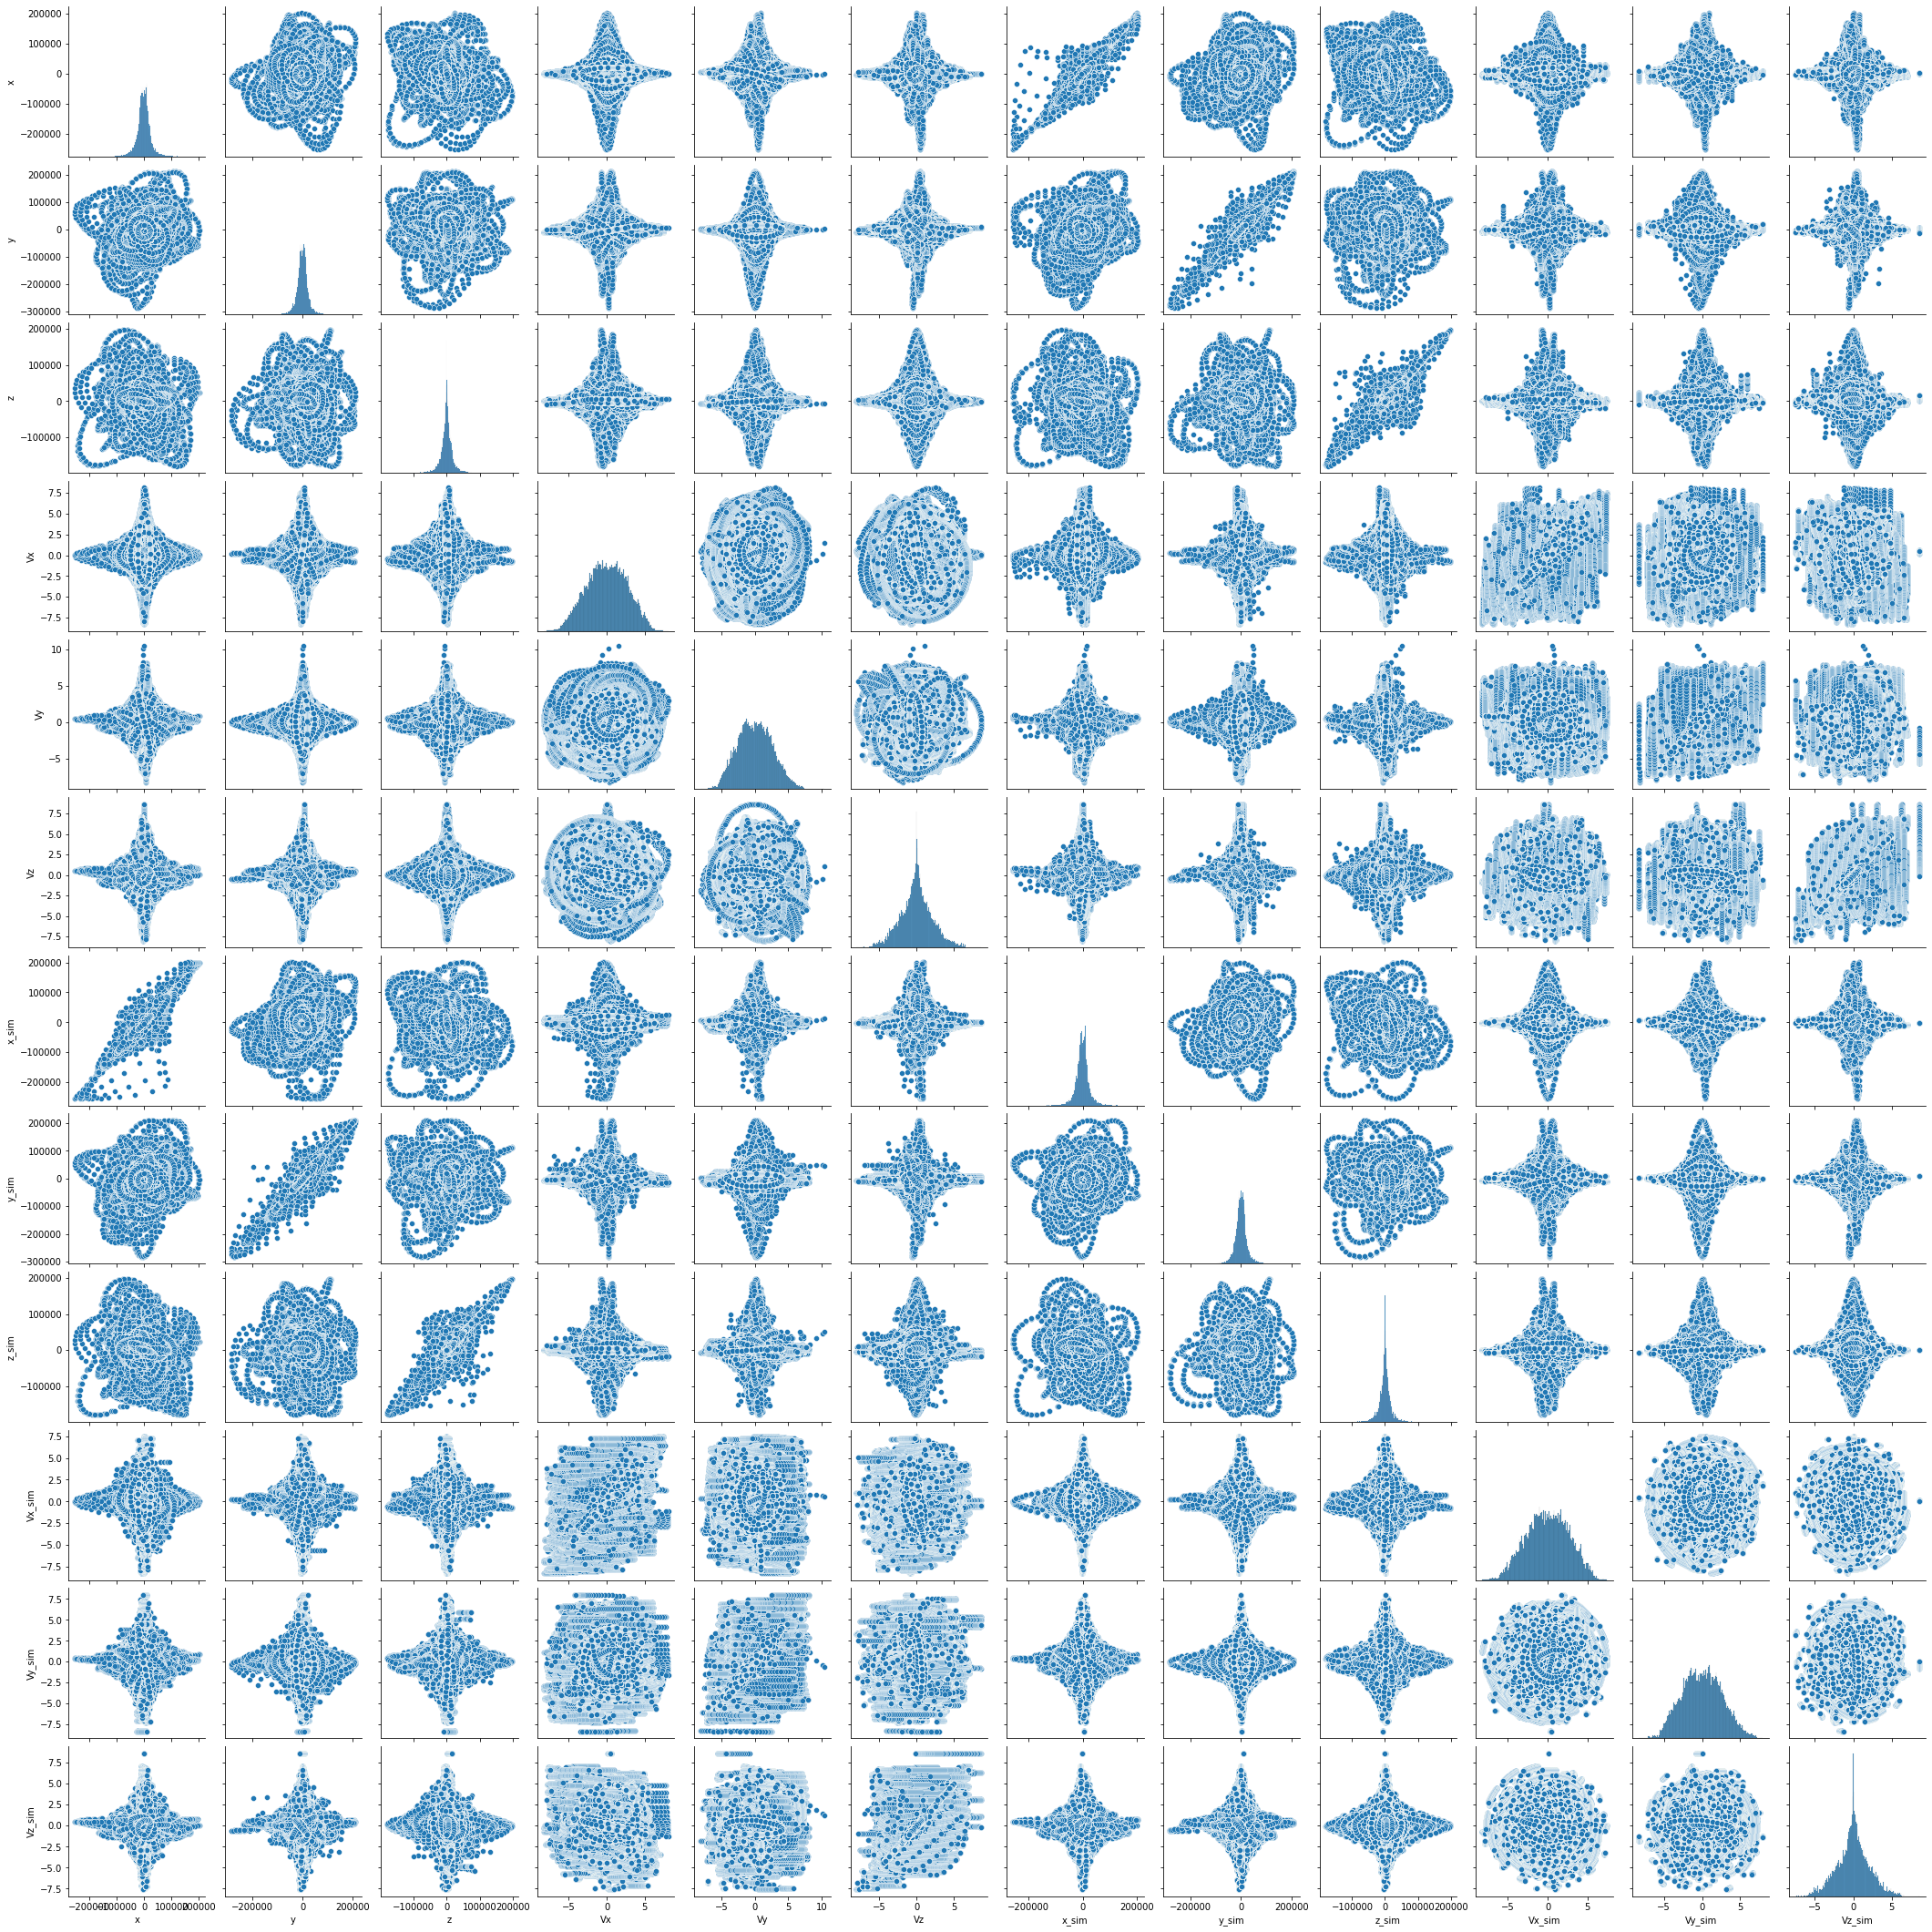

In [37]:
#pairplot
sns.pairplot(data)

In [38]:
# split into train test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(337162, 6) (166065, 6) (337162, 6) (166065, 6)


In [39]:
def train (model, x_train, y_train):
  model.fit(x_train, y_train)
  predictions = model.predict(x_test)
  print("Accuracy: ",model.score(y_test, predictions)*100)
  print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y_test, predictions)))
  print("MAE:",metrics.mean_absolute_error(y_test, predictions))
  print("MSE:",metrics.mean_squared_error(y_test, predictions))

In [40]:
model = LinearRegression(normalize=True)
print("Model Report: Linear Regression")
train(model, x_train, y_train)

Model Report: Linear Regression
Accuracy:  94.61394662281225
RMSE : 3905
MAE: 1239.5347172745103
MSE: 15246028.254481787


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [41]:
predictions = model.predict(x_test)

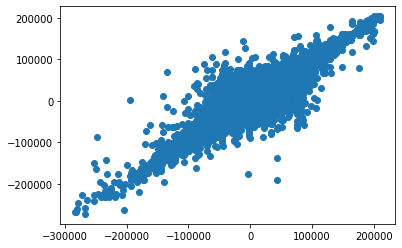

In [42]:
plt.scatter(y_test, predictions)

In [43]:
model = Ridge(normalize=True)
print("Model Report: Ridge")
train(model, x_train, y_train)

Model Report: Ridge
Accuracy:  94.57092538471173
RMSE : 9118
MAE: 4368.442636081393
MSE: 83133346.55032085


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [44]:
model = Lasso()
print("Model Report: Lasso")
train(model, x_train, y_train)

Model Report: Lasso
Accuracy:  94.61389995972044
RMSE : 3905
MAE: 1239.5586018988026
MSE: 15246039.767218446


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [45]:
# Fitting Decision Tree Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
print("Model Report: Decision Tree")
train(model, x_train, y_train)

Model Report: Decision Tree
Accuracy:  95.5581593062631
RMSE : 2426
MAE: 281.1928171439881
MSE: 5886912.42519866


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [46]:
# fit the model
model = RandomForestRegressor()
print("Model Report: Random Forest")
train(model, x_train, y_train)

Model Report: Random Forest
Accuracy:  97.5442558846983
RMSE : 1864
MAE: 280.7961459450315
MSE: 3475233.478164206


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
